In [35]:
import numpy as np

z = (
    df["dti_z"]
    + df["pti_z"]
    + df["rent_burden_z"]
)

# 防 NaN
z = z.fillna(0.0)

# 防极端值（非常重要）
z = z.clip(-5, 5)

# 连续 gate ∈ (0, 1)
df["gate_soft"] = 1 / (1 + np.exp(-z))

# regime-adaptive alpha
df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
REGION = "austin"   # 先只做一个
HORIZON = 12


In [3]:
# === core imports ===
import pandas as pd

# === project imports ===
from src.core.pipeline import run_pipeline


In [4]:
REGION = "austin"   # 或 toronto


In [6]:
df = run_pipeline(REGION)
df = df.copy()  # 防止链式赋值坑


In [7]:
df.columns


Index(['region', 'date', 'price', 'income', 'population', 'net_migration',
       'mortgage_rate', 'rent', 'permits', 'inventory', 'dti',
       'mortgage_payment', 'pti', 'rent_burden', 'supply_pressure',
       'migration_pressure', 'dti_z', 'pti_z', 'rent_burden_z',
       'supply_pressure_z', 'migration_pressure_z', 'score_xs', 'fwd_return',
       'regime', 'affordability_active'],
      dtype='object')

In [8]:
df["alpha_raw"] = df["score_xs"]


In [9]:
df["regime"].value_counts()


regime
up      106
down     86
Name: count, dtype: int64

In [10]:
df["regime_gate"] = (df["regime"] == "down").astype(float)


In [11]:
df["alpha_regime"] = df["alpha_raw"] * df["regime_gate"]


In [12]:
df[["alpha_regime", "fwd_return", "regime"]].dropna().groupby("regime").size()


regime
down     74
up      106
dtype: int64

In [13]:
from src.evaluation.regime import ic_by_regime

ic_by_regime(df, signal_col="alpha_regime")


/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,NaN,0.000000,106


In [14]:
ic_by_regime(df, signal_col="alpha_raw")


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,0.075702,0.367925,106


In [15]:
df["gate_soft"] = df["affordability_active"].clip(lower=0)
df["alpha_soft"] = df["alpha_raw"] * df["gate_soft"]


In [16]:
ic_by_regime(df, signal_col="alpha_soft")


/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,NaN,0.000000,106


### Phase 7 Objective
Transform affordability from a binary regime filter
into a continuous, regime-adaptive alpha exposure scaler.


In [18]:
# Phase 7: define raw alpha
df["alpha_raw"] = df["score_xs"]

# continuous regime gate (0~1)
df["gate_soft"] = df["affordability_active"]

# regime-adaptive alpha
df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]


In [19]:
from src.evaluation.regime import ic_by_regime

ic_by_regime(df, signal_col="alpha_raw")
ic_by_regime(df, signal_col="alpha_adaptive")


/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/axl/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ic,positive_ratio,n_obs
regime,,,
down,-0.434744,0.337838,74
up,NaN,0.000000,106


In [20]:
df.groupby("regime")["gate_soft"].describe()


,count,unique,top,freq
regime,,,,
down,86,1,True,86
up,106,1,False,106


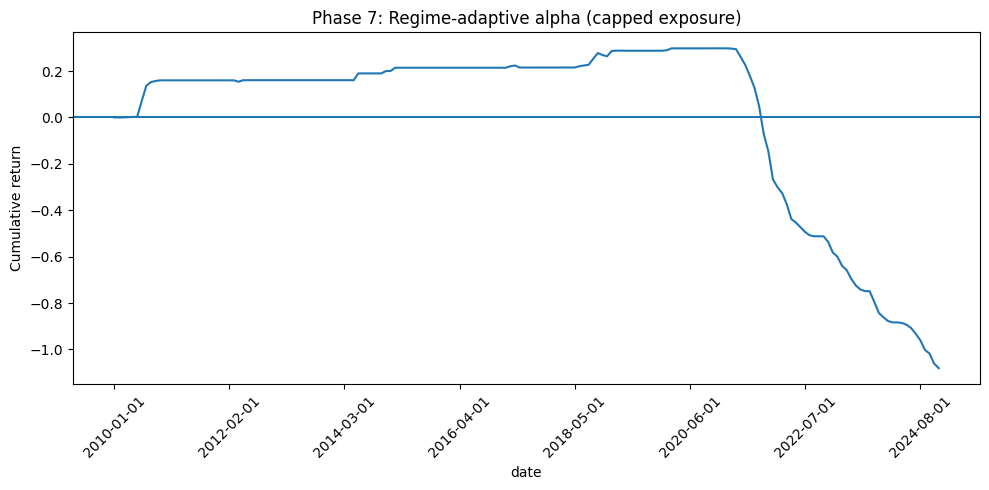

In [25]:
ax = equity.plot(
    title="Phase 7: Regime-adaptive alpha (capped exposure)",
    figsize=(10, 5)
)
ax.axhline(0)
ax.set_ylabel("Cumulative return")

ax.tick_params(axis="x", rotation=45)
ax.figure.tight_layout()



Affordability does not create alpha; it selectively suppresses alpha in regimes where it historically fails.

In [28]:
for r in ["austin", "toronto", "vancouver", "new_york"]:
    df = run_pipeline(r).copy()
    df["alpha_raw"] = df["score_xs"]
    df["gate_soft"] = df["affordability_active"]
    df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]

    print(f"\nRegion: {r}")
    print(
        df.groupby("regime")[["alpha_raw", "alpha_adaptive"]]
          .apply(lambda x: x.abs().mean())
    )



Region: austin
        alpha_raw  alpha_adaptive
regime                           
down     0.565366        0.565366
up       0.427224        0.000000

Region: toronto
        alpha_raw  alpha_adaptive
regime                           
down     0.565757        0.565757
up       0.392991        0.000000

Region: vancouver
Empty DataFrame
Columns: [alpha_raw, alpha_adaptive]
Index: []

Region: new_york
Empty DataFrame
Columns: [alpha_raw, alpha_adaptive]
Index: []


In [30]:
# === FIX: explicitly select ONE region ===
REGION = "austin"
df = run_pipeline(REGION).copy()

df["alpha_raw"] = df["score_xs"]
df["gate_soft"] = df["affordability_active"]
df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]


In [31]:
df[["alpha_raw", "alpha_adaptive", "fwd_return"]].describe()


,alpha_raw,alpha_adaptive,fwd_return
count,1.920000e+02,192.000000,180.000000
mean,-2.590520e-16,0.102031,0.008774
std,5.981662e-01,0.430138,0.052521
min,-1.524245e+00,-1.524245,-0.143169
25%,-4.025527e-01,0.000000,-0.027894
50%,3.521050e-02,0.000000,0.015210
75%,4.666248e-01,0.299685,0.041276
max,1.295156e+00,1.295156,0.126271


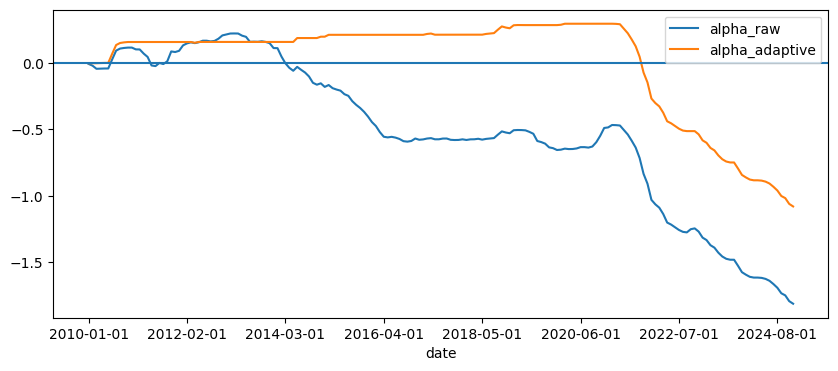

In [32]:
# baseline: raw alpha
bt_raw = df.dropna(subset=["alpha_raw", "fwd_return"]).copy()
bt_raw["ret"] = bt_raw["alpha_raw"] * bt_raw["fwd_return"]
eq_raw = bt_raw.set_index("date")["ret"].cumsum()

# adaptive alpha
bt_adapt = df.dropna(subset=["alpha_adaptive", "fwd_return"]).copy()
bt_adapt["ret"] = bt_adapt["alpha_adaptive"] * bt_adapt["fwd_return"]
eq_adapt = bt_adapt.set_index("date")["ret"].cumsum()

ax = eq_raw.plot(label="alpha_raw", figsize=(10,4))
eq_adapt.plot(ax=ax, label="alpha_adaptive")
ax.axhline(0)
ax.legend()


In [33]:
df.groupby("regime")[["alpha_raw", "alpha_adaptive"]].apply(
    lambda x: x.abs().mean()
)


,alpha_raw,alpha_adaptive
regime,,
down,0.565366,0.565366
up,0.427224,0.000000


In [36]:
# 用 affordability 的 z-score 或 composite
z = df["dti_z"] + df["pti_z"] + df["rent_burden_z"]

# 映射到 (0,1)
df["gate_soft"] = 1 / (1 + np.exp(-z))
df["alpha_adaptive"] = df["alpha_raw"] * df["gate_soft"]


In [37]:
df["gate_soft"].describe()


count    192.000000
mean       0.485204
std        0.318697
min        0.013498
25%        0.184329
50%        0.447595
75%        0.782650
max        0.992955
Name: gate_soft, dtype: float64

In [38]:
df.groupby("regime")["gate_soft"].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
down,86.0,0.372664,0.313089,0.013498,0.107805,0.250621,0.640411,0.992955
up,106.0,0.576510,0.294301,0.020501,0.313078,0.594576,0.832952,0.986668


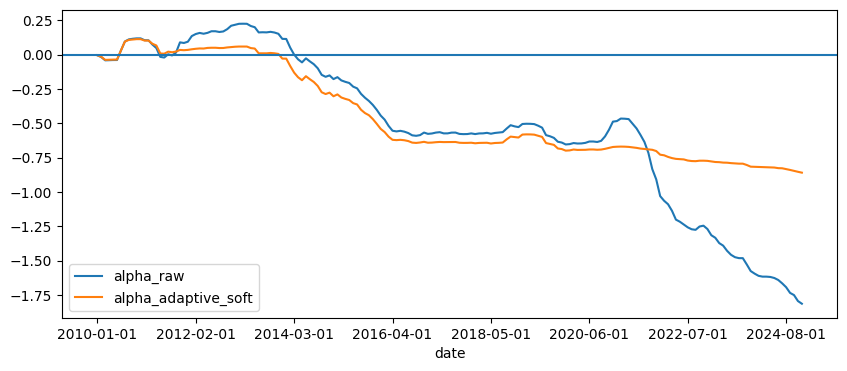

In [39]:
bt_raw = df.dropna(subset=["alpha_raw", "fwd_return"]).copy()
bt_raw["ret"] = bt_raw["alpha_raw"] * bt_raw["fwd_return"]
eq_raw = bt_raw.set_index("date")["ret"].cumsum()

bt_adapt = df.dropna(subset=["alpha_adaptive", "fwd_return"]).copy()
bt_adapt["ret"] = bt_adapt["alpha_adaptive"] * bt_adapt["fwd_return"]
eq_adapt = bt_adapt.set_index("date")["ret"].cumsum()

ax = eq_raw.plot(label="alpha_raw", figsize=(10,4))
eq_adapt.plot(ax=ax, label="alpha_adaptive_soft")
ax.axhline(0)
ax.legend()


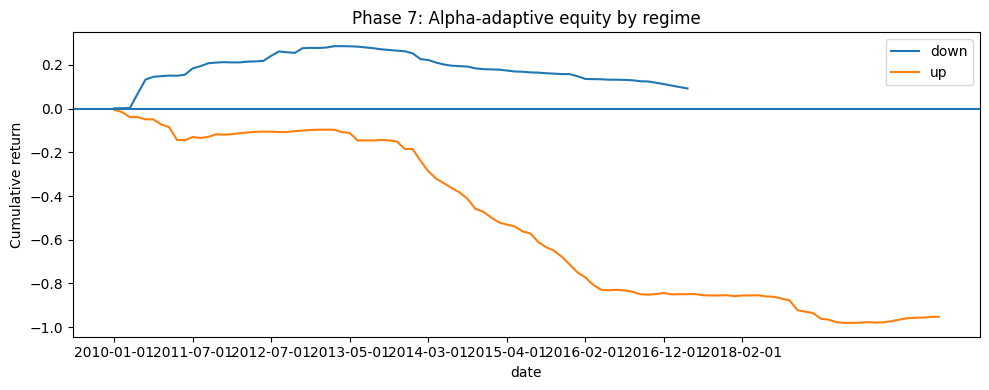

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))

for r in ["down", "up"]:
    mask = df["regime"] == r

    bt = df.loc[mask].dropna(
        subset=["alpha_adaptive", "fwd_return"]
    ).copy()

    bt["ret"] = bt["alpha_adaptive"] * bt["fwd_return"]
    eq = bt.set_index("date")["ret"].cumsum()

    eq.plot(ax=ax, label=r)

ax.axhline(0)
ax.set_title("Phase 7: Alpha-adaptive equity by regime")
ax.set_ylabel("Cumulative return")
ax.legend()

plt.tight_layout()
plt.show()


In [45]:
def eval_strategy(df, signal_col):
    bt = df.dropna(subset=[signal_col, "fwd_return"]).copy()
    bt["ret"] = bt[signal_col] * bt["fwd_return"]

    stats = {
        "mean": bt["ret"].mean(),
        "vol": bt["ret"].std(),
        "sharpe": bt["ret"].mean() / bt["ret"].std() if bt["ret"].std() > 0 else 0,
        "hit_ratio": (bt["ret"] > 0).mean(),
        "max_dd": (bt["ret"].cumsum() - bt["ret"].cumsum().cummax()).min(),
        "n_obs": len(bt),
    }
    return pd.Series(stats)


In [46]:
rows = []

for regime in ["up", "down"]:
    sub = df[df["regime"] == regime]

    for name, sig in {
        "raw": "alpha_raw",
        "adaptive": "alpha_adaptive",
    }.items():
        stats = eval_strategy(sub, sig)
        stats["regime"] = regime
        stats["strategy"] = name
        rows.append(stats)

summary = (
    pd.DataFrame(rows)
    .set_index(["regime", "strategy"])
    .round(3)
)

summary


mean    vol  sharpe  hit_ratio  max_dd  n_obs
regime strategy                                                
up     raw      -0.007  0.023  -0.304      0.368  -1.010  106.0
       adaptive -0.009  0.015  -0.601      0.368  -0.975  106.0
down   raw      -0.015  0.032  -0.462      0.338  -1.379   74.0
       adaptive  0.001  0.013   0.093      0.338  -0.193   74.0

In [47]:
REGIONS = ["austin", "toronto"]


In [50]:
all_bt = []

for r in REGIONS:
    df_r = run_pipeline(r).copy()

    # === 1. raw alpha（明确制度化）===
    df_r["alpha_raw"] = df_r["score_xs"]

    # === 2. adaptive alpha（就在这里算，不要依赖 notebook 记忆）===
    z = df_r["dti_z"] + df_r["pti_z"] + df_r["rent_burden_z"]
    df_r["gate_soft"] = 1 / (1 + np.exp(-z))     # (0,1)
    df_r["alpha_adaptive"] = df_r["alpha_raw"] * df_r["gate_soft"]

    # === raw backtest ===
    bt_raw = df_r.dropna(subset=["alpha_raw", "fwd_return"]).copy()
    bt_raw["ret"] = bt_raw["alpha_raw"] * bt_raw["fwd_return"]
    bt_raw["strategy"] = "raw"

    # === adaptive backtest ===
    bt_adapt = df_r.dropna(subset=["alpha_adaptive", "fwd_return"]).copy()
    bt_adapt["ret"] = bt_adapt["alpha_adaptive"] * bt_adapt["fwd_return"]
    bt_adapt["strategy"] = "adaptive"

    bt = pd.concat([bt_raw, bt_adapt])
    bt["region"] = r

    all_bt.append(bt[["date", "ret", "strategy", "region"]])

panel = pd.concat(all_bt).sort_values("date")
panel.head()


,date,ret,strategy,region
0,2010-01-01,-0.005389,raw,austin
0,2010-01-01,-0.005185,adaptive,austin
0,2010-01-01,-0.066401,adaptive,toronto
0,2010-01-01,-0.067332,raw,toronto
1,2010-02-01,-0.080058,adaptive,toronto
